<a href="https://colab.research.google.com/github/ambideXtrous9/Brand-Logo-Detection-using-TransferLearning-Flickr27/blob/main/Flickr27_Xception_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install imutils
!pip install wget
!pip install split-folders
!pip install timm

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=b9de19b205448849587c1e6b4051dfbad7b27847a14210619b171cc7e173bb15
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
     |████████████████████████████████| 431 kB 5.1 MB/s 


In [47]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import timm
import numpy as np
import os
import wget
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## Downloading Dataset

In [3]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [4]:
!ls

flickr_logos_27_dataset.tar.gz	sample_data


In [5]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

101842944/101827904 [==============================] - 9s 0us/step


In [6]:
import tarfile

fname = 'flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
fname = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [8]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [11]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [12]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [13]:
dtdir = './flickr_logos_27_dataset_images/'

In [14]:
im = df[0][0]

In [15]:
size = df.iloc[:,3:]

In [16]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [17]:
img = os.path.join(dtdir,im)

In [18]:
size = size.values.tolist()

In [19]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

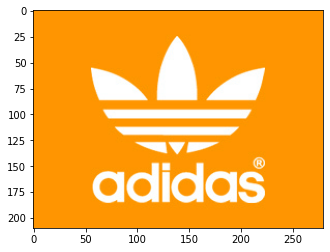

In [20]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

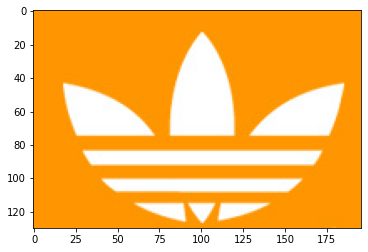

In [21]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [22]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [23]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

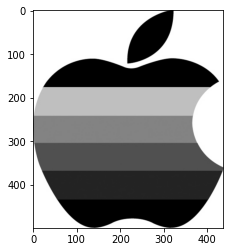

In [24]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [25]:
y = list(set(list(Y)))
y.sort()

In [26]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [27]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [28]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [29]:
HEIGHT = 224
WIDTH =  224
BS = 256

## Removing Corrupt Images 

In [30]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [31]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [32]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [33]:

for i in range(len(A)):
    try:
        destrain = os.path.join(dest,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [34]:
imagePaths = list(paths.list_images(dest))

LOGOS/Heineken/4458514217.jpg


(224, 224, 3)

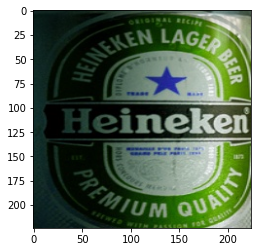

In [35]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Train Val Split

In [36]:
path = 'LOGOS'

In [37]:
splitfolders.ratio(path, output="data", seed=42, ratio=(0.8,0.2))

Copying files: 944 files [00:00, 6892.04 files/s]


## Image Augmentation

In [38]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(WIDTH,HEIGHT))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
coljtr = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
raf = transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0)
rrsc = transforms.RandomResizedCrop(size=WIDTH, scale=(0.8, 1.0))
ccp  = transforms.CenterCrop(size=WIDTH)  # Image net standards
nrml = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1421: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1436: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


In [39]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])
valTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])

In [40]:
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root='./data/train',transform=trainTransforms)
valDataset = ImageFolder(root='./data/val', transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 755 samples...
[INFO] validation dataset contains 189 samples...


In [41]:
# create training and validation set dataloaders
print("[INFO] creating training and validation set dataloaders...")
trainDataLoader = DataLoader(trainDataset, batch_size=BS, shuffle=True)
valDataLoader = DataLoader(valDataset, batch_size=BS,shuffle=True)

[INFO] creating training and validation set dataloaders...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


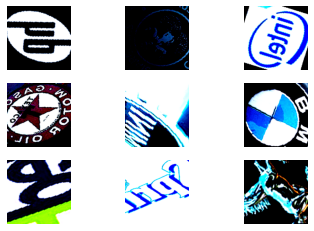

In [42]:
examples = iter(valDataLoader)
example_data, example_targets = examples.next()
for i in range(9):
    plt.subplot(3,3,i+1)
    img =example_data[i].cpu().numpy().T
    plt.imshow(img)
    plt.axis("off")
plt.show() 

In [43]:
import torchvision.models as models


In [44]:
print(trainDataset.class_to_idx)

{'Adidas': 0, 'Apple': 1, 'BMW': 2, 'Citroen': 3, 'Cocacola': 4, 'DHL': 5, 'Fedex': 6, 'Ferrari': 7, 'Ford': 8, 'Google': 9, 'HP': 10, 'Heineken': 11, 'Intel': 12, 'McDonalds': 13, 'Mini': 14, 'Nbc': 15, 'Nike': 16, 'Pepsi': 17, 'Porsche': 18, 'Puma': 19, 'RedBull': 20, 'Sprite': 21, 'Starbucks': 22, 'Texaco': 23, 'Unicef': 24, 'Vodafone': 25, 'Yahoo': 26}


## Model Architecture - Xception!

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [48]:
model = timm.create_model('xception', pretrained=True)
model.aux_logits=False

# Freeze training for all layers
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
                      nn.BatchNorm1d(model.fc.in_features),
                      nn.Linear(model.fc.in_features, 256), 
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True),
                      nn.BatchNorm1d(256),
                      nn.Linear(256, len(trainDataset.classes)),
                      nn.LogSoftmax(dim=1))

model = model.to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


## Loss Function and Optimizer

In [49]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

## Train Function

In [50]:
def train(epoch):
  model.train()
  net_loss = 0
  correct = 0
  for batch_idx, (data, target) in enumerate(trainDataLoader):
    (data, target) = (data.to(device), target.to(device))
    optimizer.zero_grad()
    output = model(data)
    loss = loss_func(output, target)
    output = torch.exp(output)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    loss.backward()
    optimizer.step()
    
    net_loss = net_loss + loss.item()
  acc = correct / len(trainDataLoader.dataset)
  return net_loss,acc

## Test Function

In [51]:
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in valDataLoader:
      (data, target) = (data.to(device), target.to(device))
      output = model(data)
      test_loss += loss_func(output, target).item()
      output = torch.exp(output)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(valDataLoader.dataset)
  acc = correct / len(valDataLoader.dataset)
  return test_loss,acc

## Driver Code

In [52]:
LOSSTR = []
ACCTE = []
LOSSTE = []
ACCTR = []
import time
n_epochs = 200
for epoch in range(1, n_epochs + 1):
  start = time.time()
  print("--- Epoch {} ---".format(epoch))
  epoch_loss,tracc = train(epoch)
  LOSSTR.append(epoch_loss)
  ACCTR.append(tracc)
  print("\tTrain Accuracy = {} || Train Loss  = {} ".format(tracc,epoch_loss))
  tloss,tacc =  test()
  print("\tTest Accuracy =  {} || Test Loss = {} ".format(tacc,tloss))
  ACCTE.append(tacc)
  LOSSTE.append(tloss)
  stop = time.time()
  print("\tTraining time = ", (stop - start))

--- Epoch 1 ---
	Train Accuracy = 0.1192053034901619 || Train Loss  = 9.56243085861206 
	Test Accuracy =  0.27513226866722107 || Test Loss = 0.01650663279982471 
	Training time =  14.92531156539917
--- Epoch 2 ---
	Train Accuracy = 0.4556291401386261 || Train Loss  = 7.019217491149902 
	Test Accuracy =  0.4920634627342224 || Test Loss = 0.015148523623350436 
	Training time =  14.542562007904053
--- Epoch 3 ---
	Train Accuracy = 0.5841059684753418 || Train Loss  = 5.952718019485474 
	Test Accuracy =  0.555555522441864 || Test Loss = 0.013860683592538985 
	Training time =  14.583958625793457
--- Epoch 4 ---
	Train Accuracy = 0.6715232133865356 || Train Loss  = 5.027016997337341 
	Test Accuracy =  0.6296296119689941 || Test Loss = 0.012518035040961372 
	Training time =  14.585038900375366
--- Epoch 5 ---
	Train Accuracy = 0.7205297946929932 || Train Loss  = 4.574455976486206 
	Test Accuracy =  0.6455026268959045 || Test Loss = 0.011492129986879056 
	Training time =  14.70071268081665
--- 

## Accuracy - Loss Plot

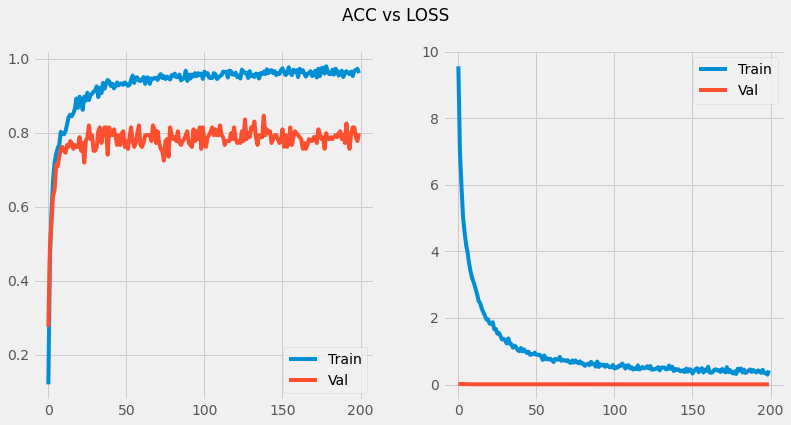

In [61]:
xx = np.arange(n_epochs)
plt.style.use("fivethirtyeight")

acctr = torch.Tensor(ACCTR).detach().cpu().numpy()
lsstr = torch.Tensor(LOSSTR).detach().cpu().numpy()
accte = torch.Tensor(ACCTE).detach().cpu().numpy()
lsste = torch.Tensor(LOSSTE).detach().cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6))
fig.suptitle('ACC vs LOSS')
ax1.plot(xx, acctr,label='Train')
ax1.plot(xx,accte,label='Val')
ax1.legend(loc="best")
ax2.plot(xx, lsstr,label='Train')
ax2.plot(xx, lsste,label='Val')
ax2.legend(loc="best")
plt.show()

## Prediction On Test Images

In [54]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

In [55]:
def predimg(path):
    from PIL import Image
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    plt.show() 
    model.eval()
    with torch.no_grad():
      img =  load_img(path)
      mean = [0.485, 0.456, 0.406] 
      std = [0.229, 0.224, 0.225]
      transform_norm = transforms.Compose([transforms.ToTensor(), 
      transforms.Resize((224,224)),transforms.Normalize(mean, std)])
      img_normalized = transform_norm(img).float()
      img_normalized = img_normalized.unsqueeze_(0)
      img = torch.from_numpy(np.asarray(img)).permute(2, 0, 1)
      img = img_normalized.to(device)
      output = model(img)
      output = torch.exp(output)
      index = output.data.cpu().numpy().argmax()
      result = list(np.around(output.data.cpu().numpy()*100,1))
      print(result)
      print("PREDICTED CLASS = ",trainDataset.classes[index])

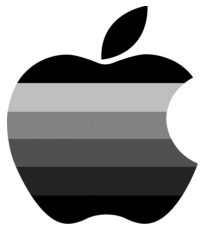

[array([  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.], dtype=float32)]
PREDICTED CLASS =  Apple


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  app.launch_new_instance()


In [56]:
predimg(testimage[8])

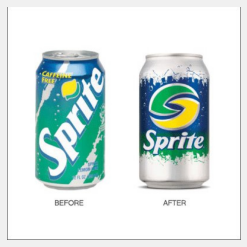

[array([ 0.1,  4.2,  0.3,  0.8,  0.1,  0. ,  0. ,  0.6,  2.3,  1.9,  0.1,
        1.1,  0.3,  0. ,  0.1,  0.5,  0. ,  0. ,  0.4,  0.5,  0.5, 85.4,
        0.6,  0. ,  0. ,  0. ,  0. ], dtype=float32)]
PREDICTED CLASS =  Sprite


In [64]:
predimg(testimage[5])

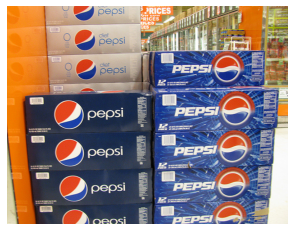

[array([ 1.5,  1.8,  3.4,  5. ,  2. ,  2.9,  0.1,  2.7,  0.2,  0.9,  1.4,
        0.8,  0.4,  0.4,  0.6,  6. , 28.7, 31.3,  0.1,  1.1,  0.3,  0.1,
        0.3,  5.2,  2.2,  0.2,  0.5], dtype=float32)]
PREDICTED CLASS =  Pepsi


In [58]:
predimg(testimage[13])

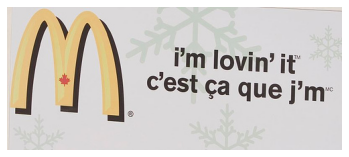

[array([ 2.6,  0. ,  0. ,  0.1, 20.7,  4.7,  0.1,  0. ,  0.5,  0.3,  0. ,
        2.8,  0.2, 60.3,  1.2,  0. ,  0.6,  0. ,  0.5,  0. ,  0.1,  0. ,
        1.7,  0.2,  0.4,  2.1,  1. ], dtype=float32)]
PREDICTED CLASS =  McDonalds


In [59]:
predimg(testimage[22])

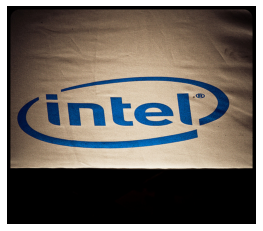

[array([ 1.8,  1.2,  0.5,  4.8,  0. ,  1.6,  2.1,  0. ,  0.2,  0. ,  0.3,
        0.2, 71.9,  0.5,  6.1,  0. ,  0.6,  2.1,  0. ,  2.5,  0. ,  0.6,
        0.1,  0. ,  1.2,  0.3,  1.1], dtype=float32)]
PREDICTED CLASS =  Intel


In [60]:
predimg(testimage[31])

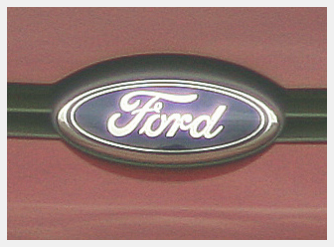

[array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1, 92.2,  0. ,  0. ,
        0. ,  0. ,  0. ,  7.1,  0. ,  0. ,  0. ,  0.1,  0.1,  0. ,  0. ,
        0.3,  0. ,  0. ,  0.1,  0. ], dtype=float32)]
PREDICTED CLASS =  Ford


In [71]:
predimg(testimage[63])

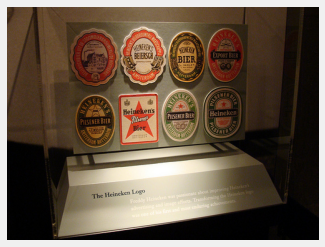

[array([ 4.5,  0. ,  0. ,  0.5,  1.5,  0.2,  0. ,  0.1,  0.5,  0. ,  0. ,
       74.6,  0. ,  0. , 15.3,  0. ,  0. ,  0. ,  0.2,  0.2,  0.7,  0. ,
        0.4,  0. ,  0. ,  1. ,  0. ], dtype=float32)]
PREDICTED CLASS =  Heineken


In [72]:
predimg(testimage[85])

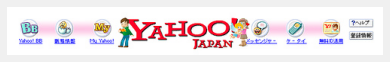

[array([ 0.1,  0.1,  0.1,  0. ,  0.4,  1.8,  0. ,  0. ,  0.1, 14.7,  0.1,
        0. ,  2.7,  0.1,  0.1,  0.2,  1.1,  0. ,  0.2,  0. ,  0.2,  0.5,
        0. ,  0. ,  1.2,  3.2, 72.9], dtype=float32)]
PREDICTED CLASS =  Yahoo


In [76]:
predimg(testimage[45])

## Some Mispredictions!

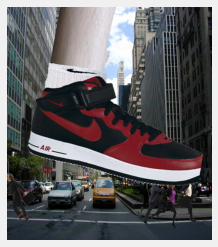

[array([ 1.8,  9.7,  0. ,  1.2,  0.8,  0.2,  0.1,  4.6,  0. ,  0.3,  0.2,
        0.2,  0.1,  0.3,  0.3,  2. ,  2.5, 17.3,  0.6, 18. ,  5.6,  1.2,
        0.1, 32.1,  0.1,  0.5,  0.5], dtype=float32)]
PREDICTED CLASS =  Texaco


In [77]:
predimg(testimage[80])

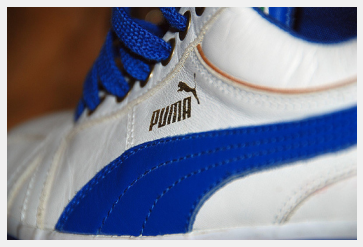

[array([ 0.1,  5.2,  0.9,  0.6,  0.3,  0.1,  0.1,  0.1,  2. ,  0.2,  0. ,
        0.3,  0.5,  0. ,  0.3,  0. ,  1.8,  2.9,  0.2,  1.1,  0.3, 80.5,
        0. ,  0.6,  1.1,  0.3,  0. ], dtype=float32)]
PREDICTED CLASS =  Sprite


In [83]:
predimg(testimage[4])